In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
warnings.filterwarnings('ignore')

In [2]:
df_new = pd.read_pickle(r'C:\Users\nishi\Desktop\EECS 731 - Data Science\Project\df_new.pkl')

In [6]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

df_new = df_new.sample(frac=1).reset_index(drop=True)


1.12.0


In [7]:
X = df_new[['month','day','hour','PULocationID','DOLocationID','airport',
            'RatecodeID','passenger_count','payment_type','trip_type','weekend_Trip']]
y = df_new[['fare_amount']]

In [8]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size = 0.10, random_state = 42)

In [6]:
# Shuffle the training set
# order = np.argsort(np.random.random(train_labels.shape))
# train_data = np.array(train_data)
#train_labels = np.array(train_labels)
#train_data = train_data[order]
#train_labels = train_labels[order]

In [7]:
print("Training set: {}".format(train_data.shape))  # 404 examples, 13 features
print("Testing set:  {}".format(test_data.shape))   # 102 examples, 13 features

Training set: (2024739, 1, 11)
Testing set:  (224972, 11)


In [9]:
# Normalizing Features

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

In [10]:
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu,
                       input_shape=(train_data.shape[1],)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                768       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,993
Trainable params: 4,993
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

# Store training stats
history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

Wall time: 18 ms


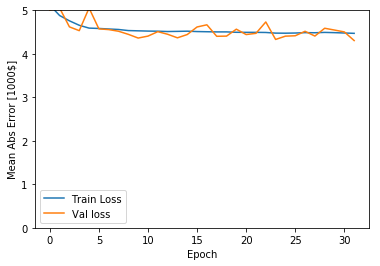

In [17]:
%%time
import matplotlib.pyplot as plt


def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [1000$]')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0, 5])

plot_history(history)


.........................................................Wall time: 38min 56s


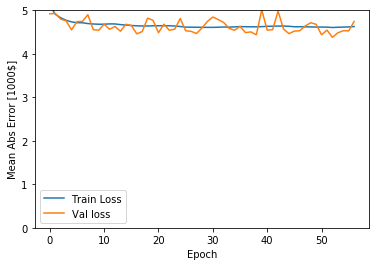

In [18]:
%%time
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

In [47]:
%%time
[loss, mae] = model.evaluate(test_data[['month','day','hour','PULocationID','DOLocationID','airport',
            'RatecodeID','passenger_count','payment_type','trip_type','weekend_Trip']], test_labels, verbose=0)

print("Testing set Mean Abs Error: ${:7.2f}".format(mae))

Testing set Mean Abs Error: $   4.74
Wall time: 2.92 s


Wall time: 2.58 s


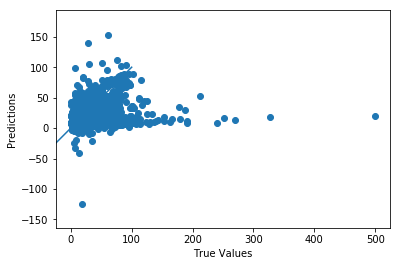

In [44]:
%%time
test_predictions = model.predict(test_data[['month','day','hour','PULocationID','DOLocationID','airport',
            'RatecodeID','passenger_count','payment_type','trip_type','weekend_Trip']])

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])

In [37]:
result = test_data
result['predicted_fare'] = test_predictions
result['actual_fare'] = test_labels
result['difference'] = abs(result['predicted_fare']-result['actual_fare'])

In [38]:
result.head()

,month,day,hour,PULocationID,DOLocationID,airport,RatecodeID,passenger_count,payment_type,trip_type,weekend_Trip,prediction,predicted_fare,actual_fare,difference
1937401,-1.195031,0.926048,0.516968,-0.485246,-0.689826,-0.129629,-0.102041,-0.339135,0.781744,-0.092421,-0.41242,6.621886,6.621886,6.5,0.121886
868829,0.271530,0.926048,0.985506,-1.382993,-0.209474,-0.129629,-0.102041,-0.339135,-0.951079,-0.092421,-0.41242,16.126501,16.126501,13.5,2.626501
1992601,1.738090,-0.091544,0.360789,1.940012,-0.209474,-0.129629,-0.102041,-0.339135,-0.951079,-0.092421,-0.41242,9.544806,9.544806,5.5,4.044806
1952741,-1.195031,0.417252,-0.107749,-0.927420,-0.780704,-0.129629,-0.102041,-0.339135,-0.951079,-0.092421,-0.41242,10.733490,10.733490,21.5,10.766510
1832239,1.738090,-0.091544,-1.044824,-0.485246,-1.131231,-0.129629,-0.102041,1.630080,-0.951079,-0.092421,-0.41242,11.547729,11.547729,6.0,5.547729


In [42]:
print("Model Accuracy % : " +str((result[result['difference'] < 3].shape[0]/result.shape[0]) * 100)[:5])

Model Accuracy % : 43.93


Wall time: 30.7 ms


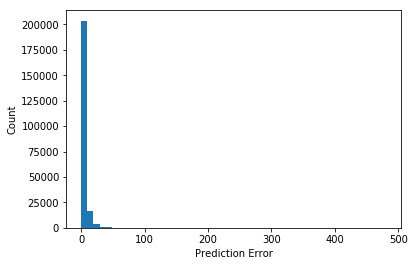

In [40]:
%%time
plt.hist(result['difference'], bins = 50)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")